In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Load the dataset
df = pd.read_csv('mental_submissions.csv')


# Convert 'created' to datetime
df['created'] = pd.to_datetime(df['created'])

# Filter: Keep posts after 2023
df = df[df['created'].dt.year >= 2023]

# Drop rows with NA in 'text' column
df = df.dropna(subset=['text'])

print(f"Posts after 2023 with non-empty text: {len(df)}")

# Save filtered data
df.to_csv('reddit_filtered.csv', index=False)

print("Filtered data saved to 'reddit_filtered.csv' ✅")

Posts after 2023 with non-empty text: 220002
Filtered data saved to 'reddit_filtered.csv' ✅


In [2]:
# Step 2: Load filtered data
df_filtered = pd.read_csv('reddit_filtered.csv')

# Clean text function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = ' '.join(text.split())
    return text

# Clean title and text
df_filtered['title'] = df_filtered['title'].apply(clean_text)
df_filtered['text'] = df_filtered['text'].apply(clean_text)

df_filtered = df_filtered[~df_filtered['text'].str.strip().isin(['', '[deleted]'])]

# Add year and year_month for analysis
df_filtered['created'] = pd.to_datetime(df_filtered['created'])
df_filtered['year'] = df_filtered['created'].dt.year
df_filtered['year_month'] = df_filtered['created'].dt.to_period('M')


print(f"Final cleaned posts: {len(df_filtered)} ✅")
print(df_filtered.head())

Final cleaned posts: 208442 ✅
                   author                                              title  \
1       u/uncle_senpaiUWU                                          question?   
2  u/utwpoken_whteishgurl                    people are disgusting in morals   
4          u/Shadowtorest  My expierence with different mentalhealth grou...   
5            u/xcharmanda                         How to release frustration   
6            u/Sunnyskipp          Mental health impacting job opportunities   

   score             created  \
1    1.0 2023-01-01 00:13:00   
2    0.0 2023-01-01 00:17:00   
4    0.0 2023-01-01 00:24:00   
5    1.0 2023-01-01 00:31:00   
6    1.0 2023-01-01 00:41:00   

                                                link  \
1  https://www.reddit.com/r/mentalhealth/comments...   
2  https://www.reddit.com/r/mentalhealth/comments...   
4  https://www.reddit.com/r/mentalhealth/comments...   
5  https://www.reddit.com/r/mentalhealth/comments...   
6  https://www.r

In [20]:
unique_authors = df_filtered['author'].nunique()
print(f"Total unique authors: {unique_authors}")


Total unique authors: 135595


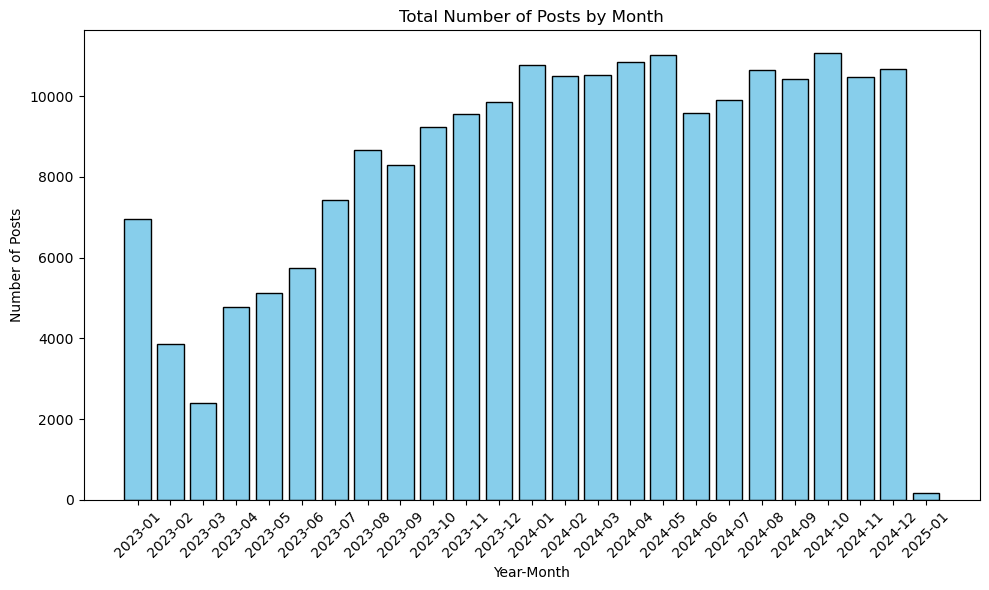

In [11]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Group by year_month and count posts
posts_per_month = df_filtered.groupby('year_month').size().reset_index(name='post_count')

# Plot bar chart
plt.figure(figsize=(10,6))
plt.bar(posts_per_month['year_month'].astype(str), posts_per_month['post_count'], color='skyblue', edgecolor='black')
plt.xticks(rotation=45)
plt.title('Total Number of Posts by Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()


In [22]:
average_score = df_filtered['score'].mean()
print(f"Average score of posts: {average_score:.2f}")
print(df_filtered['score'].describe())

Average score of posts: 2.94
count    208442.000000
mean          2.936673
std          15.088616
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1080.000000
Name: score, dtype: float64


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jeet/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                text  sentiment_score
1  So I'm depressed as ever I want to die I can't...          -0.7257
2  This isnt actually an "incel" comment But the ...           0.4767
4  Hey, I have some problems myself and like most...           0.9937
5  I’m realizing that frustration is a big trigge...          -0.9460
6  I might have autism/ADHD, I'm waiting on a dia...          -0.9895
sentiment
Negative    106439
Positive     68656
Neutral      33347
Name: count, dtype: int64


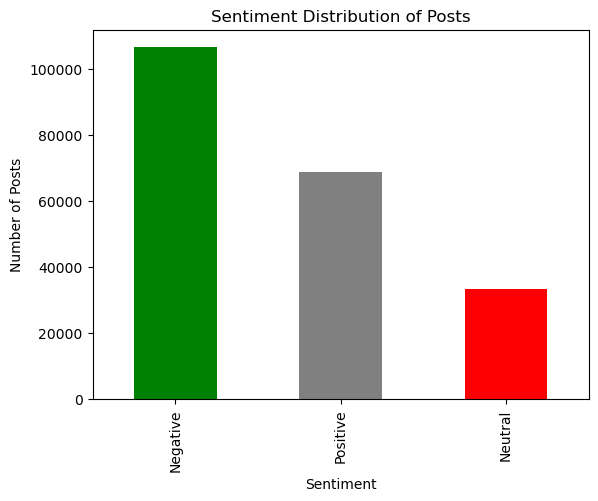

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Apply sentiment analysis
df_filtered['sentiment_score'] = df_filtered['text'].apply(get_sentiment)

# Check first few rows with sentiment
print(df_filtered[['text', 'sentiment_score']].head())


def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_filtered['sentiment'] = df_filtered['sentiment_score'].apply(sentiment_category)

# Count of sentiment categories
print(df_filtered['sentiment'].value_counts())


df_filtered['sentiment'].value_counts().plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Sentiment Distribution of Posts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()


In [ ]:
from transformers import pipeline
import pandas as pd

# Initialize classifier (you can do this once)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

candidate_labels = ["finance", "not finance"]

# Function to classify single post
def classify_finance(text):
    # Run zero-shot classification
    result = classifier(text, candidate_labels)
    # Return top label (finance/not finance)
    return result['labels'][0]

# Apply classification on 'text' column (this may take some time depending on data size)
df_filtered['finance_label'] = df_filtered['text'].apply(classify_finance)

# Count finance-related posts
finance_post_count = (df_filtered['finance_label'] == 'finance').sum()

print(f"Number of finance-related posts: {finance_post_count} out of {len(df_filtered)} total posts")


In [ ]:
from transformers import pipeline
import pandas as pd

# Load cleaned DataFrame
test_df = df_filtered.sample(1000)
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3", device="mps")

candidate_labels = ["finance", "not finance"]

# Function to classify post text
def classify_finance(text):
    result = classifier(text, candidate_labels)
    return result['labels'][0], result['scores'][0]

# Apply classification
test_df[['finance_label', 'finance_score']] = test_df['text'].apply(
    lambda x: pd.Series(classify_finance(x))
)

# Count and display
finance_count = (test_df['finance_label'] == 'finance').sum()
print(f"Total finance-related posts: {finance_count}")


Device set to use mps


Total finance-related posts: 56


In [8]:
import pandas as pd
from transformers import pipeline
import re

# Example financial keywords list (you can expand)
financial_keywords = ['stock', 'market', 'invest', 'loan', 'debt', 'bank', 'finance', 'rent', 'paycheck', 'mortgage', 'unemploy']
df_filtered = df_filtered.sample(1000)
def contains_financial_keywords(text):
    text = text.lower()
    return any(re.search(rf'\b{kw}\b', text) for kw in financial_keywords)

# Pre-filter step: Label obvious financial posts
df_filtered['pre_filter_finance'] = df_filtered['text'].apply(contains_financial_keywords)

print(f"Pre-filtered likely finance posts: {df_filtered['pre_filter_finance'].sum()} / {len(df_filtered)}")

# Only classify uncertain posts
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3", device="mps")
candidate_labels = ["finance", "not finance"]

def classify_finance(text):
    result = classifier(text, candidate_labels)
    return result['labels'][0], result['scores'][0]

# Skip classification where pre-filter already says finance=True
df_filtered[['finance_label', 'finance_score']] = df_filtered.apply(
    lambda row: ('finance', 1.0) if row['pre_filter_finance'] else pd.Series(classify_finance(row['text'])),
    axis=1
)

# Count final finance posts
finance_total = (df_filtered['finance_label'] == 'finance').sum()
print(f"Total finance-related posts after pre-filtering + classification: {finance_total}")


Pre-filtered likely finance posts: 16 / 1000


Device set to use mps


Total finance-related posts after pre-filtering + classification: 69


In [ ]:
from transformers import pipeline

# Load zero-shot classification pipeline with distilbart-mnli
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3")

# Example posts
posts = [
    "Lost my job and can't pay rent this month.",
    "I got a raise at work today!",
    "My car got repossessed because I missed payments.",
    "I enjoy my work as a software engineer.",
    "I am mentally unfit",
    "I am not feeling well I have some family issues",
    "my boss earn good salary but he is toxic",
Some infos about me tho, I am a technical lead at an IT firm, age 26, I had rough family background and life but I was able to find some moderate success in life, has a well paid job and a good work life balance and from a third world country. I have a normal+ look, not to the point of being handsome tho. So The story is I had one girl that I really like since I was at age 17. She had trust issues with boys since her exes cheated on her. I treat her well for two years, we were so close and asked her out but I got rejected, even back then I was already successful among the students, already well known among the industry. I got really sad but I moved on with my life but remains good friend to that girl, still beside her whenever she feels down. Later she got a boyfriend, dude was a nice guy and has a good look but he knew her for a few months and then they got together. I was sad again because when she rejected me , she said and I quote " I am not in the mood to date, I don't think I will be able to love or go out with someone, for a long time " . And now she got a bf, I felt so shitty, maybe the problem is with me, there must be something wrong with me. So I simply said what I felt to her and she said " You have nothing wrong, please don't compare yourself with others. bla bla" so I moved on and continue being friends with her. So after one year with that dude, they broke up. I waited for some good months and confessed that if she is now ' in the mood for love ', I am still available. She simply said ' no, I got wrong person and now I'm in a trauma '. So I let it go and as always I remains beside her as a good companion. I didn't ask anything anymore I was just happy since we were quite close. And after some time, same story happened. she got in a relationship with some good looking guy again. At this point, I had some girls chasing me and had a lot of chances for relationships. She didn't have much friends, she had me and her video games that's all. She and the dude met at an online game and later they start going out and she eventually didn't talk to me that much anymore. I felt shitty again. Maybe this time it was just really me. I built myself pretty well, I bought an apartment and a good but not expensive car, I am quite respected person in the industry but I felt it's just wrong. I was at 24 at that time. And after some time, they got broke up again and she came to me as always, talking about how she should never have a relationship anymore, I was still happy that she came back to me, I never changed through out this 8 years. And guess what, now she got a crush again, and they are mostly likely to go out soon, at this point I am on the verge of breaking down, I am okay with her not choosing me but the words she used to reject me were still fresh on my mind. " I simply don't want a relationship " " You are too overqualified for a bf " , etc. The current guy she chose doesn't even have a job and dude's still in university but as always a good looking guy. I feel like the things I built for 8 years, they don't matter anymore, A lot of girls chased me but it doesn't make me feel any better, I have achieved a lot of things but I never find success at chasing the love of my life. I keep comparing myself with her exes and bf now and my self esteem is the lowest point in life. They don't have money, car, house but who care, they got the girl I loved, this is affecting me in my works and my life, my performance dropped, I was a proud man and now I am scared to look at any other men. I need to move on, I need to gain the confidence I once had. What should I do? If this is not the place for asking this kind of question, kindly tell me where should I post. Thank you all and happy new year.]

# Candidate labels
candidate_labels = ["finance", "not finance"]

# Classify each post
for post in posts:
    result = classifier(post, candidate_labels)
    print(f"\nPost: {post}")
    print(f"Predicted Label: {result['labels'][0]} (Score: {result['scores'][0]:.2f})")


Device set to use mps:0



Post: Lost my job and can't pay rent this month.
Predicted Label: finance (Score: 0.92)

Post: I got a raise at work today!
Predicted Label: not finance (Score: 0.69)

Post: My car got repossessed because I missed payments.
Predicted Label: finance (Score: 0.96)

Post: I enjoy my work as a software engineer.
Predicted Label: not finance (Score: 0.91)

Post: I am mentally unfit
Predicted Label: not finance (Score: 0.77)

Post: I am not feeling well I have some family issues
Predicted Label: not finance (Score: 0.89)

Post: my boss earn good salary but he is toxic
Predicted Label: not finance (Score: 0.74)

Post: I have reasons for suspecting that I might have inattentive type ADHD. When it comes to checking off boxes on the DSM-V criteria, I do that enough times, though poor memory of my childhood makes it difficult for me to say if symptoms were present before age twelve. I also almost certainly have GAD, so an assessment would have to determine if my issues aren't better explained by

In [ ]:
financial_categories = {
    'general_distress': {
        'keywords': ['broke', 'struggl', 'financial stress', 'money problem', 'poor', 
                    'no money', 'paycheck to paycheck', 'drowning in debt'],
        'subcategories': {
            'debt': ['debt', 'loan', 'credit card', 'collection', 'owe', 'borrow',
                    'repayment', 'minimum payment', 'maxed out'],
            'housing': ['rent', 'evict', 'homeless', 'mortgage', 'landlord',
                       'lease', 'security deposit', 'roommate'],
            'employment': ['unemploy', 'jobless', 'laid off', 'fired', 'work',
                          'paycheck', 'wage', 'income', 'boss', 'shift'],
            'medical': ['medical bill', 'hospital debt', 'doctor bill',
                       'insurance', 'copay', 'deductible', 'prescription'],
            'family': ['child support', 'alimony', 'family expense',
                      'kids', 'children', 'single parent']
        }
    }
}

# Extract all keywords into one list
all_keywords = financial_categories['general_distress']['keywords'][:]
for subcat_list in financial_categories['general_distress']['subcategories'].values():
    all_keywords.extend(subcat_list)

# Lowercase for case insensitive matching
all_keywords = [kw.lower() for kw in all_keywords]

def contains_finance_keywords(text):
    text = text.lower()
    return any(kw in text for kw in all_keywords)


# Check if post is finance-related in either title or text
df_filtered['finance_related'] = df_filtered.apply(
    lambda row: contains_finance_keywords(row['title']) or contains_finance_keywords(row['text']),
    axis=1
)

# Count finance related posts
finance_count = df_filtered['finance_related'].sum()

print(f"Number of finance-related posts: {finance_count}")

total_posts = len(df_filtered)
percentage = (finance_count / total_posts) * 100
print(f"Percentage of finance-related posts: {percentage:.2f}%")


Number of finance-related posts: 99268
Percentage of finance-related posts: 47.62%


Financial Keyword Occurrences:
rent                     : 52102
struggl                  : 29367
owe                      : 25499
lease                    : 21891
broke                    : 11299
kids                     :  5876
poor                     :  3565
children                 :  2935
insurance                :  2793
homeless                 :  1471
debt                     :  1316
roommate                 :  1258
prescription             :  1020
no money                 :   761
loan                     :   515
collection               :   331
credit card              :   302
borrow                   :   262
evict                    :   255
landlord                 :   246
mortgage                 :   194
paycheck to paycheck     :   129
single parent            :    97
child support            :    94
medical bill             :    81
financial stress         :    74
money problem            :    69
maxed out                :    55
deductible               :    54
copay       

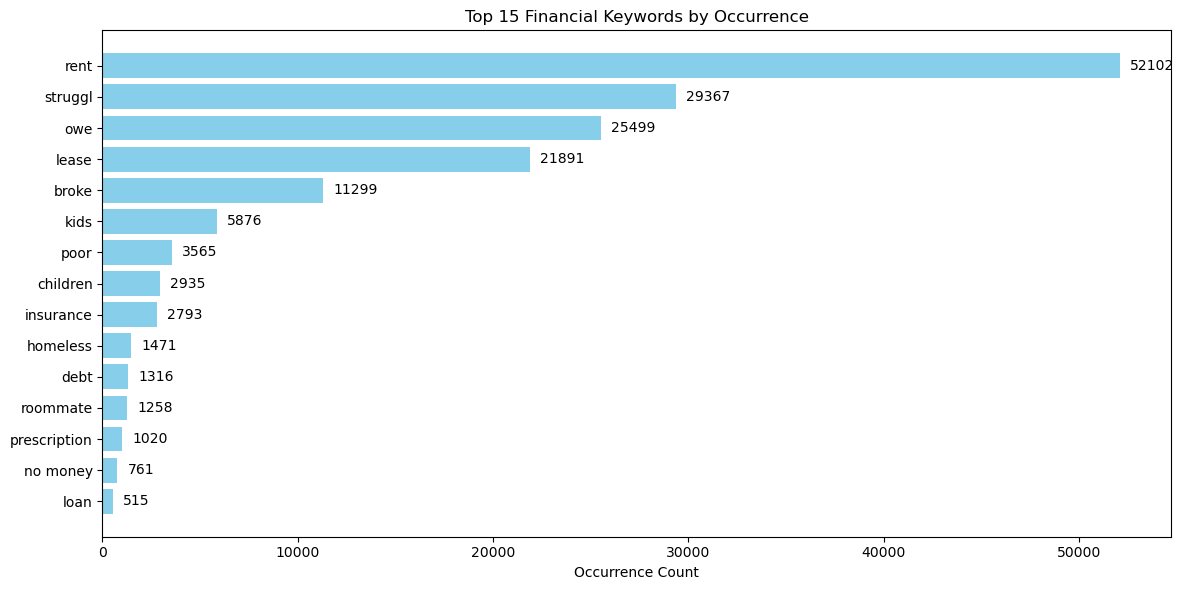

In [ ]:
import pandas as pd
import re
from collections import Counter

# Financial categories dictionary
financial_categories = {
    'general_distress': {
        'keywords': ['broke', 'struggl', 'financial stress', 'money problem', 'poor', 
                    'no money', 'paycheck to paycheck', 'drowning in debt'],
        'subcategories': {
            'debt': ['debt', 'loan', 'credit card', 'collection', 'owe', 'borrow',
                    'repayment', 'minimum payment', 'maxed out'],
            'housing': ['rent', 'evict', 'homeless', 'mortgage',
                       'lease', 'security deposit', 'roommate'],
            'employment': ['unemploy', 'jobless', 'laid off', 'fired', 'work',
                          'paycheck', 'wage', 'income', 'boss', 'shift'],
            'medical': ['medical bill', 'hospital debt', 'doctor bill',
                       'insurance', 'copay', 'deductible', 'prescription'],
            'family': ['child support', 'alimony', 'family expense',
                      'kids', 'children', 'single parent']
        }
    }
}

# Extract all keywords into one list and lowercase them
all_keywords = financial_categories['general_distress']['keywords'][:]
for subcat_list in financial_categories['general_distress']['subcategories'].values():
    all_keywords.extend(subcat_list)
all_keywords = [kw.lower() for kw in all_keywords]

# Initialize keyword counts dictionary
keyword_counts = {keyword: 0 for keyword in all_keywords}

# Function to count keyword occurrences
def count_keywords(text):
    if pd.isna(text):
        return
    text = text.lower()
    for kw in all_keywords:
        if kw in text:
            keyword_counts[kw] += 1

# Assuming df_filtered is your DataFrame with 'title' and 'text' columns
# Count keywords in both title and text columns
df_filtered['title'].apply(count_keywords)
df_filtered['text'].apply(count_keywords)

# Sort keywords by count (descending)
sorted_keyword_counts = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)

# Print all keyword counts
print("Financial Keyword Occurrences:")
print("=" * 30)
for keyword, count in sorted_keyword_counts:
    if count > 0:
        print(f"{keyword:<25}: {count:>5}")

# Print summary statistics
total_keyword_matches = sum(keyword_counts.values())
unique_keywords_used = sum(1 for count in keyword_counts.values() if count > 0)

print("\nSummary Statistics:")
print("=" * 30)
print(f"Total finance-related posts identified: {df_filtered['finance_related'].sum()}")
print(f"Total keyword matches found: {total_keyword_matches}")
print(f"Unique financial keywords detected: {unique_keywords_used}")
print(f"Top 5 keywords account for {sum(count for _, count in sorted_keyword_counts[:5])/total_keyword_matches:.1%} of all matches")

# Visualization (optional - requires matplotlib)
try:
    import matplotlib.pyplot as plt
    
    # Prepare data for top N keywords
    top_n = 15
    top_keywords = [kw for kw, cnt in sorted_keyword_counts[:top_n]]
    top_counts = [cnt for kw, cnt in sorted_keyword_counts[:top_n]]
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_keywords[::-1], top_counts[::-1], color='skyblue')
    plt.xlabel('Occurrence Count')
    plt.title(f'Top {top_n} Financial Keywords by Occurrence')
    
    # Add count labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + max(top_counts)*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(width)}', va='center')
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("\nFor visualizations, please install matplotlib: pip install matplotlib")

[nltk_data] Downloading package punkt to /Users/jeet/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jeet/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.



Financial Distress Analysis Results:
Total posts analyzed: 208442
Posts with financial distress: 4073
Percentage: 2.0%

Breakdown by category:
basic_needs         :  1597 posts
income_issues       :  1373 posts
debt_stress         :  1203 posts
financial_emotions  :   135 posts
crisis_events       :    15 posts


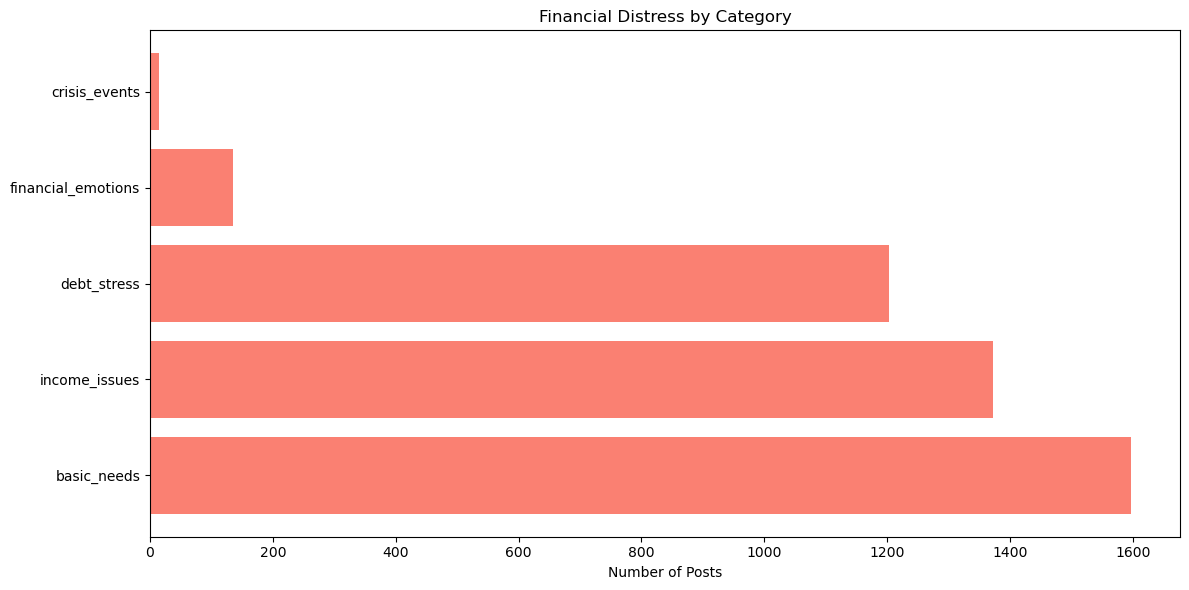

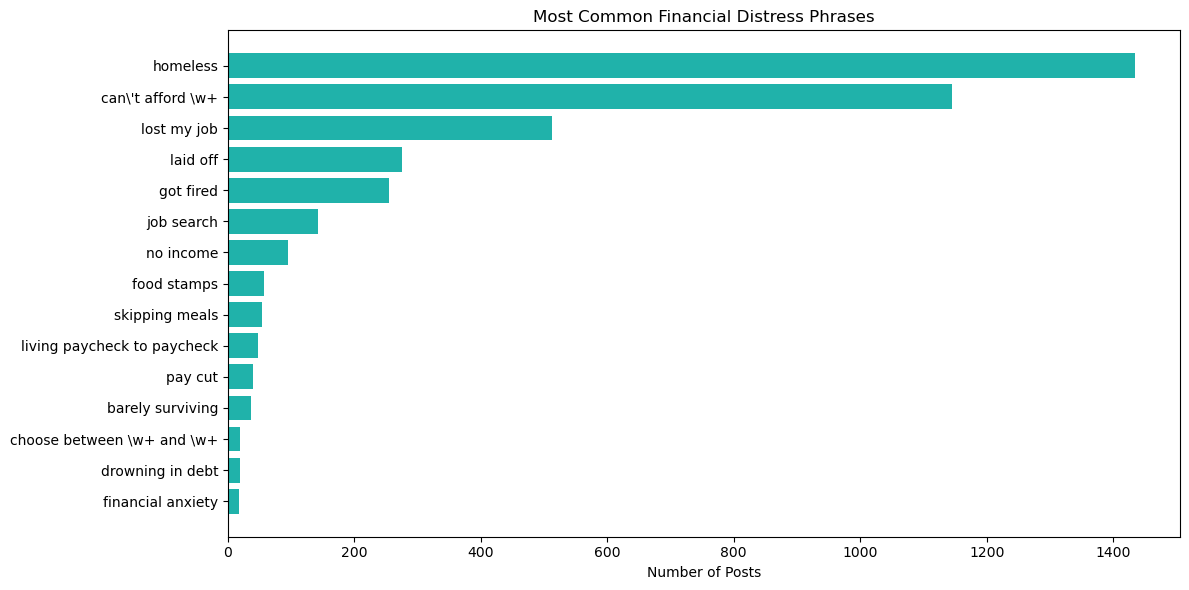

In [41]:
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Enhanced financial distress indicators with context patterns
financial_indicators = {
    'income_issues': [
        r'lost my job', r'got fired', r'laid off', r'unemployment benefits',
        r'no income', r'reduced hours', r'pay cut', r'furloughed',
        r'can\'t find work', r'job search', r'underemployed',
        r'income dropped', r'hours cut'
    ],
    
    'debt_stress': [
        r'can\'t pay my \w+', r'behind on payments', r'maxed out credit',
        r'debt collector', r'in collections', r'defaulted on',
        r'loan payment', r'high interest', r'credit score dropped',
        r'wage garnishment', r'can\'t make rent', r'can\'t afford \w+',
        r'\$\d+ debt', r'owe \$\d+'
    ],
    
    'basic_needs': [
        r'food stamps', r'skipping meals', r'can\'t pay rent',
        r'utilities shut off', r'eviction notice', r'homeless',
        r'can\'t afford groceries', r'going hungry', r'medicine costs',
        r'choose between \w+ and \w+'  # e.g. "choose between food and rent"
    ],
    
    'financial_emotions': [
        r'financial anxiety', r'money stress', r'financially overwhelmed',
        r'drowning in debt', r'financial ruin', r'economic hardship',
        r'barely surviving', r'poverty cycle', r'living paycheck to paycheck',
        r'financially desperate'
    ],
    
    'crisis_events': [
        r'medical bankruptcy', r'foreclosure notice', r'car repossessed',
        r'payday loan', r'title loan', r'pawned my', r'borrowing from family',
        r'emergency expense', r'unexpected bill', r'financial emergency'
    ]
}

# Compile all patterns for faster matching
all_patterns = []
category_patterns = defaultdict(list)
for category, patterns in financial_indicators.items():
    compiled = [re.compile(p, re.IGNORECASE) for p in patterns]
    category_patterns[category] = compiled
    all_patterns.extend(compiled)

def contains_financial_distress(text):
    """Check if text contains genuine financial distress signals"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return False
    
    text = text.lower()
    
    # Check for money amounts as context
    has_money = bool(re.search(r'\$\d+|\d+\s*(dollars|usd)', text))
    
    # Check for financial phrases with context
    found_phrases = 0
    for pattern in all_patterns:
        if pattern.search(text):
            found_phrases += 1
            if found_phrases >= 2:  # Require multiple signals
                return True
    
    # Check for financial verbs with money context
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    
    financial_verbs = {'pay', 'owe', 'borrow', 'lend', 'repay', 'afford', 'default'}
    money_nouns = {'bill', 'rent', 'debt', 'loan', 'mortgage', 'payment', 'credit'}
    
    financial_contexts = 0
    for i, (word, pos) in enumerate(tagged):
        if word in financial_verbs and i < len(tagged)-1:
            next_word = tagged[i+1][0]
            if next_word in money_nouns:
                financial_contexts += 1
                if financial_contexts >= 1 and (has_money or found_phrases >= 1):
                    return True
    
    return False

def analyze_financial_posts(df, text_col='text', title_col='title'):
    """Analyze DataFrame for financial distress posts"""
    # Initialize results
    results = {
        'category_counts': defaultdict(int),
        'keyword_details': defaultdict(list),
        'total_posts': len(df),
        'financial_posts': 0
    }
    
    # Process each post
    for _, row in df.iterrows():
        text = f"{row.get(title_col, '')} {row.get(text_col, '')}".strip()
        if not text:
            continue
            
        # Check for financial distress
        is_financial = False
        matched_keywords = set()
        
        for category, patterns in category_patterns.items():
            for pattern in patterns:
                if pattern.search(text):
                    matched_keywords.add(pattern.pattern)
                    results['category_counts'][category] += 1
                    is_financial = True
        
        if is_financial:
            results['financial_posts'] += 1
            results['keyword_details'][tuple(matched_keywords)].append(text[:100])  # Store preview
    
    return results

def visualize_results(results):
    """Create visualizations of the analysis"""
    # Category distribution
    categories = sorted(results['category_counts'].items(), key=lambda x: -x[1])
    labels, values = zip(*categories)
    
    plt.figure(figsize=(12, 6))
    plt.barh(labels, values, color='salmon')
    plt.title('Financial Distress by Category')
    plt.xlabel('Number of Posts')
    plt.tight_layout()
    plt.show()
    
    # Keyword concentration
    keyword_freq = Counter()
    for kw_set in results['keyword_details']:
        for kw in kw_set:
            keyword_freq[kw] += len(results['keyword_details'][kw_set])
    
    top_keywords = keyword_freq.most_common(15)
    plt.figure(figsize=(12, 6))
    plt.barh([kw[0] for kw in reversed(top_keywords)], 
             [kw[1] for kw in reversed(top_keywords)], 
             color='lightseagreen')
    plt.title('Most Common Financial Distress Phrases')
    plt.xlabel('Number of Posts')
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Assuming df_filtered is your DataFrame
    analysis_results = analyze_financial_posts(df_filtered)
    
    print("\nFinancial Distress Analysis Results:")
    print("=" * 50)
    print(f"Total posts analyzed: {analysis_results['total_posts']}")
    print(f"Posts with financial distress: {analysis_results['financial_posts']}")
    print(f"Percentage: {100*analysis_results['financial_posts']/analysis_results['total_posts']:.1f}%")
    
    print("\nBreakdown by category:")
    for category, count in sorted(analysis_results['category_counts'].items(), 
                                 key=lambda x: -x[1]):
        print(f"{category:<20}: {count:>5} posts")
    
    # Generate visualizations
    visualize_results(analysis_results)

In [5]:

from transformers.pipelines import pipeline
from tensorflow import keras

# Load a financial distress classifier (example: fine-tuned DistilBERT)
classifier = pipeline(
    "text-classification",
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",  # (or another financial model)
    tokenizer="distilroberta-base"
)

# Example Reddit posts
posts = [
    "Lost my job and can't pay rent this month.",  # True distress
    "I got a raise at work today!",                # False (positive finance, no distress)
    "My car got repossessed because I missed payments.",  # True distress
    "I enjoy my work as a software engineer." ,      # False (no distress)
    "I am mentally unfit ",
    "I am not feeling well I have some family issues"
]

# Classify each post
for post in posts:
    result = classifier(post)
    label = result[0]['label']
    score = result[0]['score']
    print(f"Post: {post[:60]}...")
    print(f"Prediction: {label} (Confidence: {score:.2f})")
    print("---")

Device set to use mps:0


Post: Lost my job and can't pay rent this month....
Prediction: negative (Confidence: 0.99)
---
Post: I got a raise at work today!...
Prediction: positive (Confidence: 1.00)
---
Post: My car got repossessed because I missed payments....
Prediction: negative (Confidence: 0.89)
---
Post: I enjoy my work as a software engineer....
Prediction: neutral (Confidence: 1.00)
---
Post: I am mentally unfit ...
Prediction: neutral (Confidence: 0.99)
---
Post: I am not feeling well I have some family issues...
Prediction: negative (Confidence: 0.97)
---


In [8]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

posts = [
    "Lost my job and can't pay rent this month.",
    "I got a raise at work today!. i need money",
    "My car got repossessed because I missed payments.",
    "I enjoy my work as a software engineer.",
    "I am mentally unfit ",
    "I am not feeling well I have some family issues"
]

candidate_labels = ["finance", "not finance"]

for post in posts:
    result = classifier(post, candidate_labels)
    print(f"Post: {post}")
    print(f"Prediction: {result['labels'][0]} (Confidence: {result['scores'][0]:.2f})")
    print("---")


Device set to use mps:0


Post: Lost my job and can't pay rent this month.
Prediction: finance (Confidence: 0.95)
---
Post: I got a raise at work today!. i need money
Prediction: finance (Confidence: 0.87)
---
Post: My car got repossessed because I missed payments.
Prediction: finance (Confidence: 0.97)
---
Post: I enjoy my work as a software engineer.
Prediction: not finance (Confidence: 0.91)
---
Post: I am mentally unfit 
Prediction: not finance (Confidence: 0.84)
---
Post: I am not feeling well I have some family issues
Prediction: not finance (Confidence: 0.86)
---


In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)


2.7.1
0.22.1


In [27]:
from collections import Counter
import re

# Combine all text entries into one string
all_text = ' '.join(df_filtered['text'].dropna().astype(str)).lower()

# Remove punctuation and non-alphabetic characters
all_text_clean = re.sub(r'[^a-z\s]', '', all_text)

# Tokenize by splitting on whitespace
words = all_text_clean.split()

import nltk
from nltk.corpus import stopwords

# Download stopwords if not already done
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Filter out stopwords
filtered_words = [word for word in words if word not in stop_words]

import nltk
from nltk.corpus import stopwords

# Download stopwords if not already done
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Filter out stopwords
filtered_words = [word for word in words if word not in stop_words]


word_counts = Counter(filtered_words)

# Show 20 most common words
most_common_words = word_counts.most_common(200)

print("Top 20 most frequent words:")
for word, count in most_common_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package stopwords to /Users/jeet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jeet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 most frequent words:
im: 396715
like: 292889
dont: 244907
feel: 231884
know: 168430
ive: 151883
get: 139000
want: 129983
even: 125855
time: 120773
really: 116136
life: 114754
people: 109467
cant: 108133
would: 93549
things: 88739
think: 86805
one: 85822
help: 76461
never: 76091
go: 74999
something: 73730
much: 73615
years: 71237
going: 70163
also: 68278
friends: 66678
always: 66603
day: 62244
anything: 61738
back: 57974
still: 57671
mental: 56946
way: 56657
got: 55919
work: 54503
feeling: 54110
bad: 53514
didnt: 53109
since: 52755
make: 52678
someone: 51728
could: 51409
good: 51332
need: 51274
everything: 51121
anyone: 49522
lot: 47452
anxiety: 45879
see: 45734
family: 45628
started: 45196
every: 45144
health: 44720
year: 44417
person: 43959
better: 42910
talk: 42751
school: 42287
felt: 39847
getting: 39585
say: 39359
around: 38972
told: 38834
love: 38460
said: 38271
thing: 37369
nothing: 37198
right: 36382
last: 36310
take: 36076
thoughts: 35989
trying: 35571
try: 35408
anymore

In [37]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import numpy as np

# Load model and tokenizer (similar to 'all-MiniLM-L6-v2')
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Mean pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Encode function
def encode(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    return mean_pooling(model_output, encoded_input['attention_mask'])

# Your data
keywords = [word for word, count in most_common_words]
finance_reference = ["finance", "money", "debt", "job loss", "unemployment", "expenses", "rent"]

# Get embeddings
keyword_embeddings = encode(keywords)
finance_embedding = encode(finance_reference)

# Compute cosine similarity
cosine_scores = F.cosine_similarity(
    keyword_embeddings.unsqueeze(1),
    finance_embedding.unsqueeze(0),
    dim=2
)

# Find relevant keywords
average_scores = cosine_scores.mean(dim=1).numpy()
finance_keywords = [keywords[i] for i, score in enumerate(average_scores) if score > 0.3]

print("Finance-related keywords:", finance_keywords)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Finance-related keywords: ['life', 'things', 'friends', 'work', 'everything', 'family', 'school', 'depression', 'parents', 'job', 'home', 'mom', 'making', 'dad', 'house', 'depressed', 'living', 'working']
